In [24]:
!pip install Sastrawi

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# IMPORT LIBRARY

In [47]:
import pandas as pd
import re
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import csv
import requests
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Loading Dataset

In [ ]:
#akan menampilkan 5 baris pertama dari Dataframe tersebut.
df = pd.read_csv("https://raw.githubusercontent.com/deayulianis/Proyek-Analisis-Sentimen/refs/heads/main/ulasan_tiktok.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,9f293c6a-953f-4476-9f2c-6d65d8a4f939,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tolong pihak tiktok dari tadi saya donload men...,2,0,39.4.3,2025-04-12 10:01:19,NaN,NaN,39.4.3
1,be33729a-97da-44a7-8607-cc5ff3c5a7f1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,baik sekali,5,0,NaN,2025-04-12 09:59:52,NaN,NaN,NaN
2,51d6608a-88a8-4ba6-acd8-9d836e842a4f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"gw bingung sama tiktok, komentar yg bener di A...",1,0,NaN,2025-04-12 09:59:43,NaN,NaN,NaN
3,a1db1f60-4efc-4c38-a272-cb7f26da354d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"baguss bangett ihh, adaa ajaa inspirasi baruu ...",5,0,39.3.3,2025-04-12 09:57:35,NaN,NaN,39.3.3
4,fff6f5eb-1990-4537-b994-0326044e7a32,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Mohon di perbaiki lagi soal nya saya donlod su...,3,0,NaN,2025-04-12 09:56:14,NaN,NaN,NaN


In [ ]:
# Menampilkan informasi tentang DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10000 non-null  object
 1   userName              10000 non-null  object
 2   userImage             10000 non-null  object
 3   content               10000 non-null  object
 4   score                 10000 non-null  int64 
 5   thumbsUpCount         10000 non-null  int64 
 6   reviewCreatedVersion  5951 non-null   object
 7   at                    10000 non-null  object
 8   replyContent          4 non-null      object
 9   repliedAt             4 non-null      object
 10  appVersion            5951 non-null   object
dtypes: int64(2), object(9)
memory usage: 859.5+ KB


In [ ]:
# Menangani Missing Values
# Ganti NaN di kolom 'reviewCreatedVersion' & 'appVersion' dengan "Unknown"
df['reviewCreatedVersion'].fillna("Unknown", inplace=True)
df['appVersion'].fillna("Unknown", inplace=True)

# Untuk kolom replyContent & repliedAt yang jarang terisi, bisa dibiarkan atau diisi kosong string
df['replyContent'].fillna("", inplace=True)
df['repliedAt'].fillna("", inplace=True)

<ipython-input-6-875d31ee1009>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviewCreatedVersion'].fillna("Unknown", inplace=True)
<ipython-input-6-875d31ee1009>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [ ]:
# Mengecek informasi tentang DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10000 non-null  object
 1   userName              10000 non-null  object
 2   userImage             10000 non-null  object
 3   content               10000 non-null  object
 4   score                 10000 non-null  int64 
 5   thumbsUpCount         10000 non-null  int64 
 6   reviewCreatedVersion  10000 non-null  object
 7   at                    10000 non-null  object
 8   replyContent          10000 non-null  object
 9   repliedAt             10000 non-null  object
 10  appVersion            10000 non-null  object
dtypes: int64(2), object(9)
memory usage: 859.5+ KB


*Dataset suddah bersih dari Missing Values*

# Preprocessing Text

In [ ]:
# 1. Cleaning
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # hashtag
    text = re.sub(r'RT[\s]+', '', text)        # RT
    text = re.sub(r"http\S+", '', text)        # links
    text = re.sub(r'[0-9]+', '', text)         # angka
    text = re.sub(r'[^\w\s]', '', text)        # karakter selain huruf/angka
    text = text.replace('\n', ' ')             # baris baru jadi spasi
    text = text.translate(str.maketrans('', '', string.punctuation))  # hapus tanda baca
    text = text.strip()
    return text

# 2. Case folding
def casefoldingText(text):
    return text.lower()

# 3. Ganti kata slang
slangwords = {
    "@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar",
    "bgt": "banget", "maks": "maksimal", "ga": "tidak", "gak": "tidak", "dpt": "dapat",
    "bkn": "bukan", "tdk": "tidak", "sm": "sama", "jg": "juga"
    # tambahkan lainnya sesuai kebutuhan
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = [slangwords.get(word.lower(), word) for word in words]
    return ' '.join(fixed_words)

# 4. Tokenizing (pakai RegexpTokenizer biar aman)
def tokenizingText(text):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(text)

# 5. Stopword removal
def filteringText(text):
    stop_words = set(stopwords.words('indonesian') + stopwords.words('english'))
    tambahan = ['iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'di', 'ga', 'ya', 'gaa', 'loh', 'kah', 'woi', 'woii', 'woy']
    stop_words.update(tambahan)
    return [word for word in text if word not in stop_words]

# 6. Stemming
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    return ' '.join([stemmer.stem(word) for word in words])

# 7. Balik token jadi kalimat
def toSentence(words):
    return ' '.join(words)


In [ ]:
# Preprocessing pipeline
df['text_clean'] = df['content'].apply(cleaningText)
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)
df['text_stemming'] = df['text_stopword'].apply(lambda x: stemmingText(' '.join(x)))
df['text_akhir'] = df['text_stemming'].apply(lambda x: toSentence(x.split()))

In [ ]:
df['text_akhir'].head(10)  # 10 data teratas hasil akhir preprocessing

,text_akhir
0,tolong tiktok donload menginstal mulu selesai ...
1,
2,gw bingung tiktok komentar yg bener apus gilir...
3,baguss bangett ihh adaa ajaa inspirasi baruu d...
4,mohon baik donlod menginstal masuk aplikasi
5,si tiktok blokir akun gua gua kecewa guwa uda ...
6,akun tiktok blokir tiktok laku langgar sdh coba
7,kalu apdet susah banget udah coba berkalikali ...
8,bru update update lgi yg bner aja
9,suka


# Pelabelan

In [33]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Gagal mengambil data kata positif")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Gagal mengambil data kata negatif")

# Fungsi analisis sentimen
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score -= lexicon_negative[word]

    if score > 3:
        polarity = 'positive'
    elif score < 3:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity


In [34]:
results = df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))  # Memisahkan hasil score dan label

df['polarity_score'] = results[0]
df['polarity'] = results[1]

In [35]:
print(df['polarity'].value_counts())
print(df[['text_stopword', 'polarity_score', 'polarity']].head())

polarity
positive    7211
negative    2340
neutral      449
Name: count, dtype: int64
                                       text_stopword  polarity_score  polarity
0  [tolong, tiktok, donload, menginstal, mulu, se...              24  positive
1                                                 []               0  negative
2  [gw, bingung, tiktok, komentar, yg, bener, apu...              14  positive
3  [baguss, bangett, ihh, adaa, ajaa, inspirasi, ...              10  positive
4  [mohon, perbaiki, donlod, menginstal, masuk, a...              11  positive


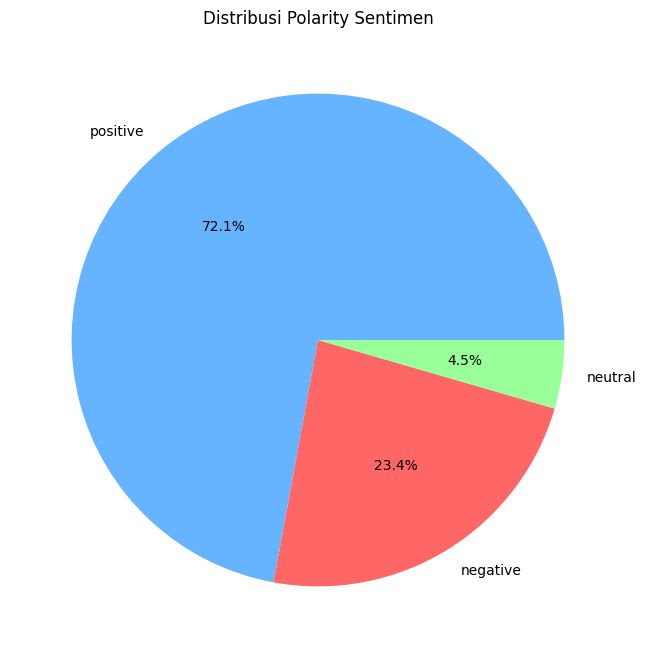

In [37]:
# Menghitung jumlah setiap kategori polarity
polarity_counts = df['polarity'].value_counts()

# Membuat diagram lingkaran
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', colors=['#66b3ff','#ff6666','#99ff99'])
plt.title('Distribusi Polarity Sentimen')
plt.show()

# Eksplorasi Label

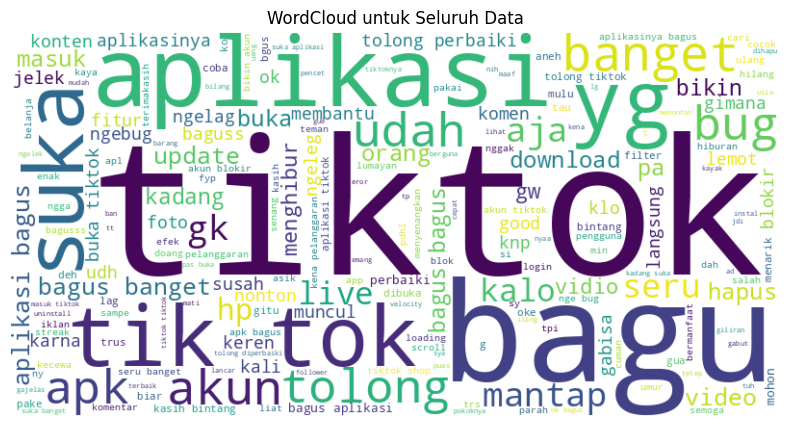

In [41]:
# 1. WordCloud secara umum (untuk seluruh teks)
# Mengubah list menjadi string dengan menggabungkan kata-kata dalam setiap baris
all_text = ' '.join([' '.join(text) for text in df['text_stopword']])

# Membuat WordCloud
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud untuk Seluruh Data')
plt.show()

Text(0.5, 1.0, 'Word')

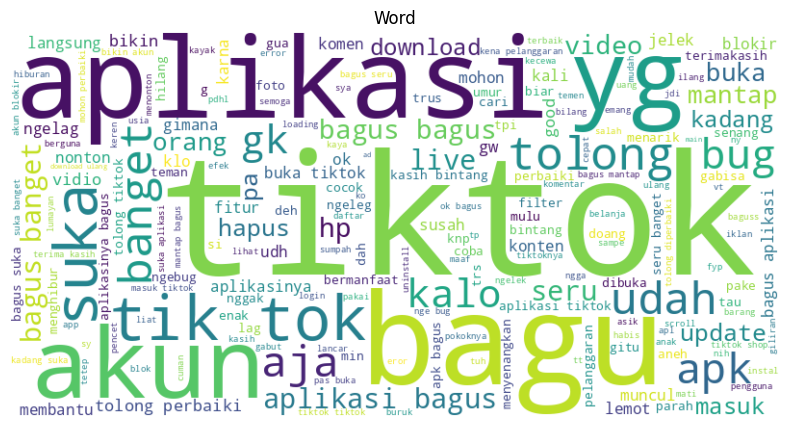

In [42]:
# 2. WordCloud untuk Positive Tweets
positive_text = ' '.join([' '.join(text) for text in df[df['polarity'] == 'positive']['text_stopword']])

# Membuat WordCloud untuk Positive Tweets
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Menampilkan WordCloud Positive
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word')

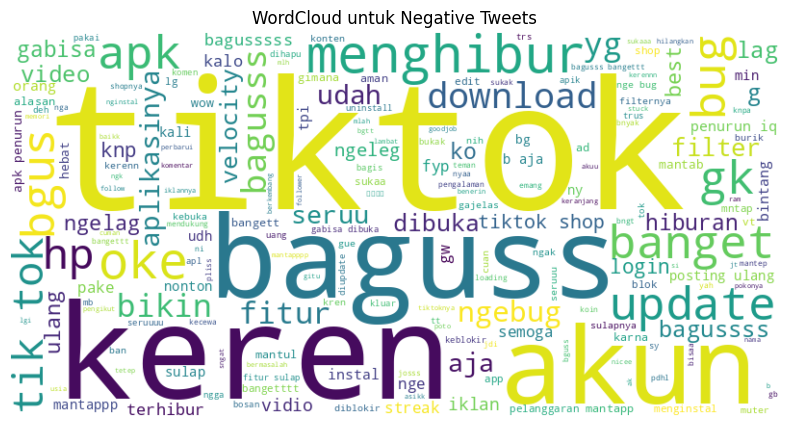

In [43]:
# 3. WordCloud untuk Negative Tweets
negative_text = ' '.join([' '.join(text) for text in df[df['polarity'] == 'negative']['text_stopword']])

# Membuat WordCloud untuk Negative Tweets
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Menampilkan WordCloud Negative
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud untuk Negative Tweets')
plt.show()

# Data Splitting dan Ekstraksi Fitur dengan TF-IDF

In [46]:
# Pastikan 'text_stopword' adalah kolom yang berisi list kata-kata. Gabungkan kata-kata menjadi string
X = [' '.join(text) for text in df['text_stopword']]  # Menggabungkan list menjadi string
y = df['polarity']  # Kolom 'polarity' yang berisi label sentimen

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
print("Hasil Ekstraksi Fitur:")
print(features_df.head())

# Bagi data menjadi data latih dan data uji (80% latih, 20% uji)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print(f"\nUkuran Data Latih: {X_train.shape}")
print(f"Ukuran Data Uji: {X_test.shape}")

Hasil Ekstraksi Fitur:
    ad  aja      akun      aman  anak  aneh  apk  apl  aplikasi  aplikasinya  \
0  0.0  0.0  0.000000  0.000000   0.0   0.0  0.0  0.0  0.000000          0.0   
1  0.0  0.0  0.000000  0.000000   0.0   0.0  0.0  0.0  0.000000          0.0   
2  0.0  0.0  0.205267  0.692114   0.0   0.0  0.0  0.0  0.000000          0.0   
3  0.0  0.0  0.000000  0.000000   0.0   0.0  0.0  0.0  0.000000          0.0   
4  0.0  0.0  0.000000  0.000000   0.0   0.0  0.0  0.0  0.366333          0.0   

   ...  umur  uninstall  update  upload  usia  velocity  video  vidio   vt  \
0  ...   0.0        0.0     0.0     0.0   0.0       0.0    0.0    0.0  0.0   
1  ...   0.0        0.0     0.0     0.0   0.0       0.0    0.0    0.0  0.0   
2  ...   0.0        0.0     0.0     0.0   0.0       0.0    0.0    0.0  0.0   
3  ...   0.0        0.0     0.0     0.0   0.0       0.0    0.0    0.0  0.0   
4  ...   0.0        0.0     0.0     0.0   0.0       0.0    0.0    0.0  0.0   

         yg  
0  0.000000  

# Modeling

In [48]:
# 1. Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# Evaluasi model
print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

Logistic Regression:
Accuracy: 0.904
              precision    recall  f1-score   support

    negative       0.81      0.90      0.85       472
     neutral       0.72      0.29      0.42        72
    positive       0.94      0.94      0.94      1456

    accuracy                           0.90      2000
   macro avg       0.82      0.71      0.73      2000
weighted avg       0.90      0.90      0.90      2000



In [52]:
print("Logistic Regression: Accuracy = 90.4%")

Logistic Regression: Accuracy = 90.4%


In [49]:
# 2. Support Vector Machine (SVM)
svm = SVC(kernel='linear')  # Coba dengan kernel linear
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Evaluasi model
print("\nSupport Vector Machine (SVM):")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


Support Vector Machine (SVM):
Accuracy: 0.908
              precision    recall  f1-score   support

    negative       0.79      0.95      0.86       472
     neutral       0.93      0.19      0.32        72
    positive       0.96      0.93      0.94      1456

    accuracy                           0.91      2000
   macro avg       0.89      0.69      0.71      2000
weighted avg       0.92      0.91      0.90      2000



In [53]:
print("Support Vector Machine (SVM): Accuracy = 90.8%")

Support Vector Machine (SVM): Accuracy = 90.8%


In [50]:
# 3. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluasi model
print("\nRandom Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest:
Accuracy: 0.907
              precision    recall  f1-score   support

    negative       0.80      0.91      0.85       472
     neutral       0.64      0.42      0.50        72
    positive       0.95      0.93      0.94      1456

    accuracy                           0.91      2000
   macro avg       0.80      0.75      0.77      2000
weighted avg       0.91      0.91      0.91      2000



In [54]:
print("Random Forest: Accuracy = 90.7%")

Random Forest: Accuracy = 90.7%
